<a href="https://colab.research.google.com/github/alexchen1999/cancer-prediction-random-forest/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest for Cancer Type Prediction Based on Gene Expression Data

Credit:
- YouTube: [Python for Machine Learning | Random Forest for Cancer Prediction | Part 1](https://www.youtube.com/watch?v=rzpL1ksWqtk&t=993s)
- Dataset: [UCI Machine Learning Repository 
gene expression cancer RNA-Seq Data Set](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq)

This notebook implements a random forest classifier using scikit-learn to train and classify cancer types based on gene expression features taken from The Cancer Genome Atlas Project (TGCA).

Link to paper: [Weinstein, John N., et al. 'The cancer genome atlas pan-cancer analysis project.' Nature genetics 45.10 (2013): 1113-1120.](https://www.nature.com/articles/ng.2764)

In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import (balanced_accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score,
                             classification_report,
                             confusion_matrix,
                             plot_confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

# Feature Selection
from sklearn.feature_selection import mutual_info_classif

# Classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
file_url='https://github.com/vappiah/Machine-Learning-Tutorials/raw/main/datasets/cancer_gene_expression.zip'
df = pd.read_csv(file_url)

# Data exploration

In [77]:
df.head()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,...,gene_7992,gene_7993,gene_7994,gene_7995,gene_7996,gene_7997,gene_7998,gene_7999,gene_8000,Cancer_Type
0,0.0,0.0,0.0,2.088413,0.0,0.0,0.0,0.0,0.550605,2.815760,...,11.558803,8.881802,6.014840,6.643534,11.740624,7.065012,9.932659,6.928584,2.088413,KIRC
1,0.0,0.0,0.0,3.205955,0.0,0.0,0.0,0.0,0.425244,2.354396,...,11.062829,9.032864,5.054193,6.432320,12.104985,7.300746,9.872796,5.039231,2.448002,KIRC
2,0.0,0.0,0.0,4.746646,0.0,0.0,0.0,0.0,2.639417,1.657091,...,12.497640,7.198160,0.943434,7.371690,11.202356,8.426588,11.176890,3.119738,4.433988,BRCA
3,0.0,0.0,0.0,1.173191,0.0,0.0,0.0,0.0,1.527371,2.732899,...,11.261713,8.725676,6.300418,6.036451,11.732303,7.559469,9.596453,2.863046,3.380342,KIRC
4,0.0,0.0,0.0,1.366532,0.0,0.0,0.0,0.0,0.000000,3.388355,...,12.241965,7.685204,5.142948,6.355788,11.493950,8.139444,10.189256,6.544487,0.839395,COAD


In [35]:
df.shape

(801, 8001)

In [78]:
df.columns[-1]

'Cancer_Type'

In [80]:
count_na = df.isnull().sum()
print(count_na)

g = [i for i in count_na if i>0]
print('Number of columns with null values:', len(g))

gene_1         0
gene_2         0
gene_3         0
gene_4         0
gene_5         0
              ..
gene_7997      0
gene_7998      0
gene_7999      0
gene_8000      0
Cancer_Type    0
Length: 8001, dtype: int64
Number of columns with null values: 0


In [37]:
print(df['Cancer_Type'].value_counts())

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Cancer_Type, dtype: int64


Text(0, 0.5, 'Value Count')

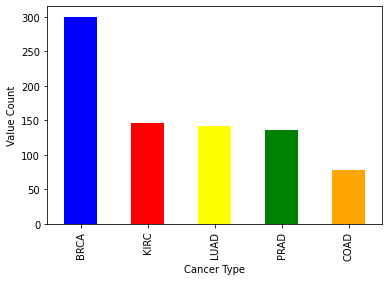

In [99]:
barplot = df['Cancer_Type'].value_counts().plot.bar(
    color=['blue', 'red', 'yellow', 'green', 'orange'])
barplot.set_xlabel('Cancer Type')
barplot.set_ylabel('Value Count')

# Data Preprocessing

In [40]:
# Separate into features and labels
X=df.iloc[:,0:-1]
y=df.iloc[:,-1]

In [41]:
label_encoder = LabelEncoder()
print(y.shape)
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)

(801,)


In [42]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [43]:
classes

array([0, 1, 2, 3, 4])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

[sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Normalizes the data

In [45]:

min_max_scaler = MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [46]:
df.iloc[:, 0:10].describe()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


In [22]:
X_train.iloc[0,3]

2.18164326123

In [23]:
X_train_norm[0,3]

0.4671305057022768

# [Mutual Information Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

Feature Selection Method
- "Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency."

In [81]:
MI = mutual_info_classif(X_train_norm, y_train)

In [82]:
n_features = 300

# Get the indices that would sort the array in ascending order, and reverse them.
# Then get the n_features indices that represent the top n_features variables based on mutual information.
selected_scores_indices = np.argsort(MI)[::-1][0:n_features]

In [83]:
MI.shape

(8000,)

In [84]:
X_train_selected = X_train_norm[:, selected_scores_indices]
X_test_selected = X_test_norm[:, selected_scores_indices]

In [85]:
X_train_selected.shape

(640, 300)

# Models
[OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

- Fits one classifier per class, in this case we have 5 classes or cancer types.
- For each classifier, the class is fitted (trained) against the other classes

> The obvious approach is to use a one-versus-the-rest approach 
(also called one-vs-all), in which we train C binary classifiers, fc(x), where the data from class c is treated as positive, and the data from all the other classes is treated as negative.

— Page 503, Machine Learning: A Probabilistic Perspective, 2012.

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- Ensemble learning to train multiple decision trees on subsamples of the data
- criterion {“gini”, “entropy”, “log_loss”}, default=”gini”
- max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”
The number of features to consider when looking for the best split:**bold text**

# Model 1: 
- Criterion: Gini
- max_features: 0.2 * `n_features`

In [86]:
RF = OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected, y_train)
y_pred = RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

In [67]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9708
precision:0.9815
recall:0.9814
f1score:0.9812


classification report


              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      1.00      1.00        28
        LUAD       0.96      0.92      0.94        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.98       161
   macro avg       0.98      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



In [68]:
#generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)

In [69]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,60,0,0,0,0
COAD,0,15,0,1,0
KIRC,0,0,28,0,0
LUAD,2,0,0,22,0
PRAD,0,0,0,0,33


Text(33.0, 0.5, 'True Labels')

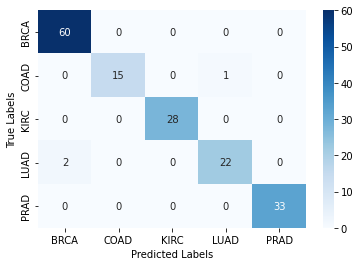

In [70]:
#visualize the confusion matrix using seaborn

sns.heatmap(cm_df,annot=True,cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


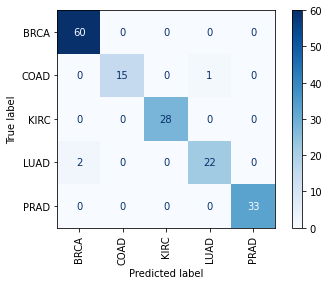

In [73]:
#visualize the confusion matrix directly
disp=plot_confusion_matrix(RF,X_test_selected,y_test,xticks_rotation='vertical',
                     cmap='Blues',display_labels=labels)

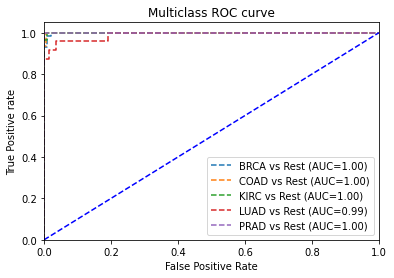

In [74]:
#roc curves will be generated for each class
#we will therefore have to binarize the y_test labels
#this is done because the probabilities(pred_prob) are calculated for each each class
#we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()    

# Model 2:
- Criterion: entropy
- max_features: sqrt

In [100]:
RF = OneVsRestClassifier(RandomForestClassifier(criterion="entropy", max_features="sqrt"))
RF.fit(X_train_selected, y_train)
y_pred = RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

In [101]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9543
precision:0.9639
recall:0.9627
f1score:0.9629


classification report


              precision    recall  f1-score   support

        BRCA       0.94      0.98      0.96        60
        COAD       1.00      0.94      0.97        16
        KIRC       1.00      0.96      0.98        28
        LUAD       0.92      0.92      0.92        24
        PRAD       1.00      0.97      0.98        33

    accuracy                           0.96       161
   macro avg       0.97      0.95      0.96       161
weighted avg       0.96      0.96      0.96       161



In [102]:
#generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)

In [103]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,59,0,0,1,0
COAD,0,15,0,1,0
KIRC,1,0,27,0,0
LUAD,2,0,0,22,0
PRAD,1,0,0,0,32


Text(33.0, 0.5, 'True Labels')

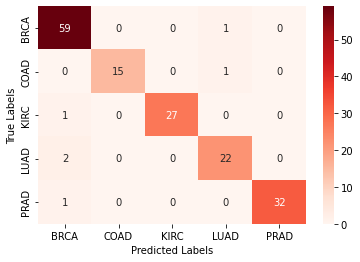

In [105]:
#visualize the confusion matrix using seaborn

sns.heatmap(cm_df,annot=True,cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


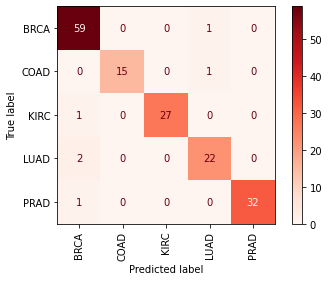

In [106]:
#visualize the confusion matrix directly
disp=plot_confusion_matrix(RF,X_test_selected,y_test,xticks_rotation='vertical',
                     cmap='Reds',display_labels=labels)

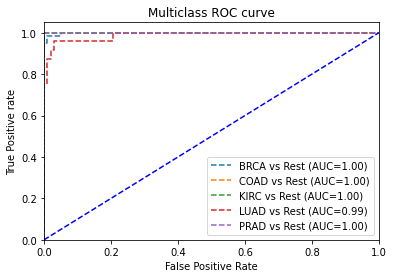

In [107]:
#roc curves will be generated for each class
#we will therefore have to binarize the y_test labels
#this is done because the probabilities(pred_prob) are calculated for each each class
#we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()    